# Kenya Sign Language Finger Spelling Detection

## 1. Business Understanding

### (a) Introduction

In a world where effective communication is the cornerstone of social interaction,there exist significant challenges for individuals with disabilities,particularly those who rely on sign language as their primary means of communication. Communication is not just a basic human right but also a fundamental requirement for participation in society,accessing essential services,and enjoying a high quality of life.

Finger Spelling is a crucial form of communication for individuals with hearing impairments.It involves using handshapes to spell out words and convey messages,making it an essential component of sign language and augmenting other communication methods.For many Deaf and Hard of Hearing individuals,fingerspelling is not just a mode of communication;it is a vital tool for expressing thoughts,emotions and ideas effectively.Despite its significance, there exist a stark communication gap between individuals who rely on fingerspelling and the boarder society.This gap often leads to social isolation,limited access to education and employment opportunities, and barriers to accessing essential services. Bridging this divide is not just a matter of convinience, its a matter of fundamental human rights and social justice.

Recognizing this, the Ministry of Public Services,Gender,Senior Citizens Affairs, and the special Program and Rehabilitative Services Division has embarked on a transformative initiative to break down the barriers faced by individuals with this kind of disability.This division focuses on providing support and services to individuals with special needs. It often encompasses services for people with disabilities, including rehabilitation,vocational training and programs aimed at improving their quality of life.

Our project will harness the power of advanced computer vision techniques to detect and interpret the intricate handshapes and movements that constitute fingerspelling.By doing so in real time, we aim to create a system that can facilitate immediate, meaningful communication between individuals with disabilities and their conterparts.Our vision is to develop an innovative solution that leverages modern technology to empower Deaf and Hard of Hearing individuals by enabling real-time fingerspelling interpretation. This project will improve the ministry's ability to provide services to individuals with disabilities,especially those who rely on fingerspelling.This will enable more effective communication between the government officials and citizens with disabilities,enhancing the quality and accessibility of services.


### (b) The Problem Statement

Effective communication is a fundamental human right and an essential component of social inclusion and participation. However individuals with hearing impairments who rely on fingerspelling as their primary means of communication face often significant communication barriers.The problem at hand is limited accessibility and inclusivity faced by individuals with hearing impairments who rely on fingerspelling.Current communication solutions do not adequately facilitate effective communication between individuals proficient in this visual-gesture language. The Ministry of Public Services,Gender, Senior Citizens Affairs and Special Program and Rehabilitative Services Division have commissioned this project to develop and implement a real-time fingerspelling detection system that can bridge the communication gap between individuals with hearing impairments to communicate effectively with the government officials,access government services, education, and employment opportunities and promote their overall social inclusion and well-being.

### (c) Defining a Metric of Success

- **Recognition Accuracy**

Achieve a recognition accuracy rate of at least 90%, measured by the percentage of correctly identified fingerspelled words out of the total fingerspelled words processed by the system.

- **Response Time**

Ensure a response time of less than 20 seconds for recognizing and translating fingerspelling gestures into text or speech in real-time.

- **Error Rate**

Maintain a low error rate, with recognition errors accounting for less than 5% of total interactions with the system.

- **Intergration success**

Intergrate the system successully into a website,ensuring seamless functionality.

### (d) The Main Objective

To develop and implement a real-time fingerspelling detection system that empowers individuals with hearing impairments to communicate effectively with the broader community,government officials and service providers,thereby promoting inclusivity,accessibility and social intergration.

### (e) Specific Objectives

- **Data Collection**

Collect a diverse and comprehensive dataset of fingerspelling gestures performed by individuals with varying signing styles,hand shapes and speeds and merge it with the already existing kaggle dataset.

- **Develop a robust hand detection system**

Create an accurate and robust hand detection system using cvzone and MediaPipe to ensure precise tracking of hand movements during fingerspelling.

- **Implement fingerspelling recognition**

Develop a recogntion component that can identify and interpret fingerspelled gestures in real-time using machine learning algorithms.

- **Real-time translation**

Intergrate a translation mechanism that converts detected fingerspelled letters into text in real-time,ensuring immediate and accessible communication.

- **User-Friendly Interface**

Design an intuitive user interface that is accessible and user-friendly, allowing individuals with disabilities to interact with the system comfortably

- **Intergration into a website**

Develop a website to intergrate the system to maximize its reach and impact.

### (f) Data Understanding

The dataset is sourced from [Kaggle](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)

**Content**: The dataset consists of images of hand signs representing the alphabet in American Sign Language (ASL). Each image is in grayscale format and has a size of 28x28 pixels. The images represent letters from A-Z, but there are no cases for J or Z as they involve hand motion.The value of the pixels range from 0 to 255, representing different shades of gray.A pixel value of 0 represents black, a pixel value of 255 represents white. Values between 0 and 255 represents various shades of gray.In the context of this dataset, the pixels collectively form an image of a hand gesture representing a letter in the American Sign Language alphabet. The different shades of gray help to define the shape and orientation of the hand in each image.

**Format**: The dataset format closely matches the classic MNIST dataset. It includes a header row of the label and pixel values of pixel1 to pixel784.

**Size**: The dataset contains 27,455 cases for training and 7,172 cases for testing.

Additional images were collected by some group members to increase the diversity and the volume of the data. There is no significant difference between fingerspelling in ASL and fingerspelling in KSL.The two can be adapted interchangerbly.

By accurately interpreting and analyzing fingerspelling, the system can help individuals with hearing impairments communicate more effectively with government officials and access government services, education, and employment opportunities. This promotes social inclusion and well-being.


## 2.  Importing Libraries


In [1]:
#importing necessary libraries
import cv2
import os
import joblib
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array
from keras import layers, initializers, optimizers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# Setting a random seed
np.random.seed(180)

plt.style.use("ggplot")

## 3. Collecting data

In [2]:
# cap = cv2.VideoCapture(0)
# detector = HandDetector(maxHands=1)

# offset = 20
# imgSize = 300

# folder = 'Data/A'
# counter = 0

# while True:
#     success, img = cap.read()
#     hands, img = detector.findHands(img)
#     if hands:
#         hand = hands[0]
#         x, y, w, h = hand['bbox']

#         imgwhite = np.ones((imgSize, imgSize, 3), np.uint8)*255

#         imgCrop =img[y-offset:y + h+offset, x-offset:x + w+offset]

#         imgCropShape = imgCrop.shape

        

#         aspectRatio = h/w
#         if aspectRatio > 1:
#             k = imgSize/h
#             wCal = math.ceil(k*w)
#             imgResize = cv2.resize(imgCrop, (wCal, imgSize))
#             imgResizeShape = imgResize.shape
#             wGap = math.ceil(imgSize-wCal)/2
#             imgwhite[:, int(wGap) : int(wCal) + int(wGap)] = imgResize

#         else:
#             k = imgSize/w
#             hCal = math.ceil(k*h)
#             imgResize = cv2.resize(imgCrop, (imgSize, hCal))

#             imgResizeShape = imgResize.shape
#             hGap = math.ceil((imgSize-hCal)/2)
#             imgwhite[int(hGap) : int(hCal) + int(hGap), :] = imgResize


#         cv2.imshow('ImageCrop', imgCrop)
#         cv2.imshow('ImageWhite', imgwhite)

#     cv2.imshow('Image', img)
#     key = cv2.waitKey(10)
#     if key == ord('s'):
#         counter += 1
#         cv2.imwrite(f'{folder}/Image_{time.time()}.jpg', imgwhite)
#         print(counter)


## 4. Reading the Data

In [3]:
# Reading train and test dataset
train = pd.read_csv("sign_mnist_train.csv")
test = pd.read_csv("sign_mnist_test.csv")

# printing first five rows of the train data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179



The dataset is structured as a table with 785 columns. Each row in the table represents an image.

The first column, ‘label’, represents the class or category of each image. In the context of hand gestures, each unique number could represent a specific gesture.

The remaining 784 columns represent individual pixel values of each image. Given there are 784 pixels, it suggests that each original image was a 28x28 pixel grayscale image. Each pixel column in the table corresponds to a specific pixel in the image grid.

The values in the pixel columns range from 0 to 255, representing the grayscale intensity at that specific pixel (0 being black and 255 being white).


In [4]:
# a class to decribe the dataset
class Describer:

    #initialize an object
    def __init__(self, df):
        self.df = df

    #checking the shape of the data
    def shape(self, name):
        return print(f"The {name} dataset has {self.df.shape[0]} entries and {self.df.shape[1]} columns")

In [5]:
#Viewing the shape of the train dataset
data = Describer(train)
data.shape("train")

The train dataset has 27455 entries and 785 columns


In [6]:
#Viewing the shape of the test dataset
data = Describer(test)
data.shape("test")

The test dataset has 7172 entries and 785 columns


In [7]:
# Displaying the column names
train.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [8]:
# reading the collected raw images
train_generator = ImageDataGenerator().flow_from_directory("Images", target_size=(28,28),
                                                           batch_size=3000)

Found 2445 images belonging to 24 classes.


The data we collected is stored in an Image folder. There are 2445 images belonging to 24 classes

In [9]:
#Getting all images and labels
train_images, train_labels = next(train_generator)

In [10]:
#Flattening images into lists of pixels
images_list = []
for img_array in train_images:
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    gray = np.expand_dims(gray, 2)
    images_list.append(gray.reshape(-1, 784).flatten().tolist())

In [11]:
#converting the images to a DataFrame
raw_img_df = pd.DataFrame(images_list)
raw_img_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,255.0,255.0,254.41301,255.0,146.244995,147.875000,147.277008,152.337006,151.109009,154.119995,...,126.717995,127.276993,131.091995,132.234009,132.244995,254.472992,255.000000,255.0,255.0,255.0
1,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,150.245010,...,125.244995,254.472992,254.402008,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
2,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,150.234009,...,130.000000,254.000000,254.885986,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
3,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,254.413010,255.000000,255.000000,255.000000,254.885986,255.0,255.0,255.0
4,255.0,255.0,255.00000,255.0,254.885986,142.472992,143.244995,144.233994,146.875000,147.875000,...,119.875000,118.234001,122.234001,118.875008,253.874985,255.000000,254.000000,255.0,255.0,255.0


In [12]:
# Generating the labels
train_labels = pd.Series([np.argmax(label)
                           for label in train_labels])

In [13]:
# Concatenating the labels and the raw picture dataframe
raw_df = pd.concat([train_labels, raw_img_df], axis=1)
raw_df.columns = train.columns

#Displaying the first 5 rows of the raw images dataframe
raw_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,11,255.0,255.0,254.41301,255.0,146.244995,147.875000,147.277008,152.337006,151.109009,...,126.717995,127.276993,131.091995,132.234009,132.244995,254.472992,255.000000,255.0,255.0,255.0
1,3,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,...,125.244995,254.472992,254.402008,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
2,5,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,...,130.000000,254.000000,254.885986,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
3,14,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,254.413010,255.000000,255.000000,255.000000,254.885986,255.0,255.0,255.0
4,21,255.0,255.0,255.00000,255.0,254.885986,142.472992,143.244995,144.233994,146.875000,...,119.875000,118.234001,122.234001,118.875008,253.874985,255.000000,254.000000,255.0,255.0,255.0


In [14]:
#splitting the raw df to train and test dataframes
train_df, test_df = train_test_split(raw_df, test_size=0.1, random_state=180)

#### Combining Datasets
The kaggle dataset labels are from 0-24 with 9 and 25 missing which represent the j and z letters that have been excluded but the raw dataset labels are from 0-23. For the two datasets to be merged, the labels should be similar.

In [15]:
# mapping the labels into correct labels
mapping_dict = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 10: 9, 11: 10,
                12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19,
                21: 20, 22: 21, 23: 22, 24: 23}

train["label"] = train["label"].map(mapping_dict)
test["label"] = test["label"].map(mapping_dict)

In [16]:
# Concatenating the collected images and the train dataset
train = pd.concat([train, train_df])
train.reset_index(drop=True, inplace=True)

# Displaying the first five rows
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107.0,118.0,127.0,134.0,139.0,143.0,146.0,150.0,153.0,...,207.0,207.0,207.0,207.0,206.0,206.0,206.0,204.0,203.0,202.0
1,6,155.0,157.0,156.0,156.0,156.0,157.0,156.0,158.0,158.0,...,69.0,149.0,128.0,87.0,94.0,163.0,175.0,103.0,135.0,149.0
2,2,187.0,188.0,188.0,187.0,187.0,186.0,187.0,188.0,187.0,...,202.0,201.0,200.0,199.0,198.0,199.0,198.0,195.0,194.0,195.0
3,2,211.0,211.0,212.0,212.0,211.0,210.0,211.0,210.0,210.0,...,235.0,234.0,233.0,231.0,230.0,226.0,225.0,222.0,229.0,163.0
4,12,164.0,167.0,170.0,172.0,176.0,179.0,180.0,184.0,185.0,...,92.0,105.0,105.0,108.0,133.0,163.0,157.0,163.0,164.0,179.0


The kaggle and our data are combined to increasing the chances of making a robust model that can generalize better to unseen data.Combining the datasets also increases the data volume allowing the models to learn from a larger variety of examples

## 4. Data Wrangling

**Splitting the Data**

In [17]:
# Splitting the train and test datasets
train_X = train.iloc[:, 1:]
train_y = train.label

test_X = test.iloc[:, 1:]
test_y = test.label

The train and test datasets are split into features (X) and labels (y). This is done so that the model can be trained on one set of data (train_X, train_y) and then evaluated on a different set (test_X, test_y) that it hasn’t seen before.

**One-Hot Encoding**

In [18]:
#onehot encoding the train and test labels
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

The labels are one-hot encoded. This is a process by which categorical variables are converted into a form that could be provided to machine learning algorithms to improve prediction. For a classification problem like this, each label needs to be converted into an array with a length equal to the number of classes, filled with zeros except for the index of the class it belongs to, which is marked with a one.

**Normalization of the Pixels**

In [19]:
# Normalizing our train and test data
train_X /= 255
test_X /= 255

The feature data is normalized by dividing by 255. This scales the data to be between 0 and 1, which can make the training process more efficient.

**Reshaping**

In [20]:
train_X_reshaped = np.array(train_X).reshape(-1, 28, 28, 1)
test_X_reshaped = np.array(test_X).reshape(-1, 28, 28, 1)

The data is reshaped from a flat 1D array into a 3D array that includes dimensions for height, width, and channels (in this case, 1 channel because the images are grayscale). This is the shape that the CNN expects for its input



**Preprocessing Images**

In [ ]:
#Preprocessing the images
def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        image = skimage.filters.gaussian(image, sigma=1)
        image = skimage.exposure.equalize_hist(image)
        # blurred = cv2.GaussianBlur(image, (3,3), 0)
        preprocessed_images.append(image)
    return np.array(preprocessed_images).reshape(-1, 28, 28, 1)


train_X_reshaped = preprocess_images(train_X_reshaped)
test_X_reshaped = preprocess_images(test_X_reshaped)

The images are preprocessed using Gaussian smoothing (to reduce noise) and histogram equalization (to improve contrast). This can help improve the model’s ability to recognize patterns in the images.

## 5. Exploratory data Analysis

- **Displaying Images**

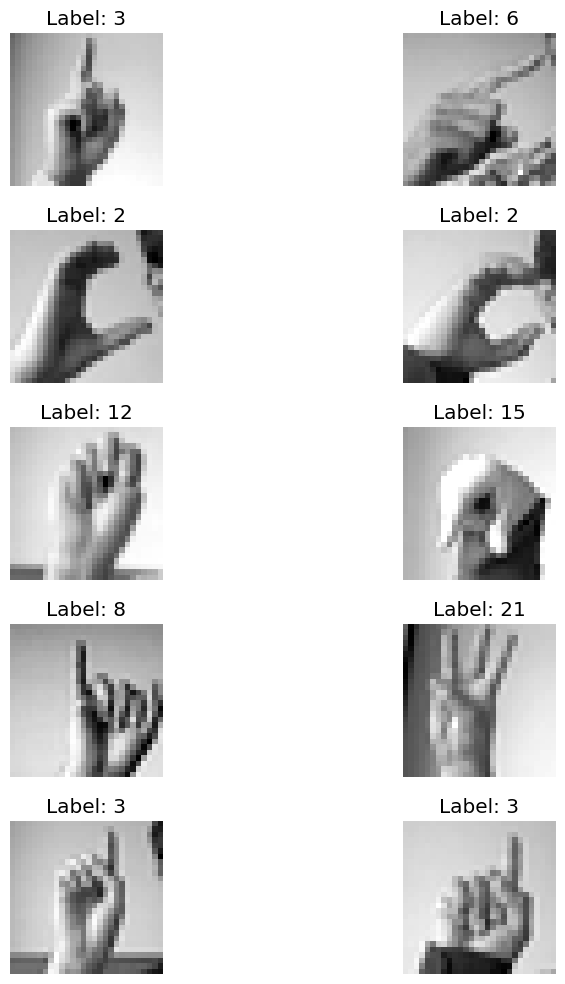

In [22]:
#displaying first 10 images
# Extract pixel values and labels
pixel_columns = train.columns[1:]
pixel_values = train[pixel_columns].values
labels = train['label'].values

# Display images
fig, axes = plt.subplots(5, 2, figsize=(8, 10))
fig.tight_layout()


for i in range(10):
    row = i // 2
    col = i % 2
    pixel_array = pixel_values[i].reshape(28, 28)
    # Display image on the corresponding subplot
    axes[row, col].imshow(pixel_array, cmap='gray')
    axes[row, col].set_title('Label: ' + str(labels[i]))
    axes[row, col].axis('off')

# Show the plot
plt.show()

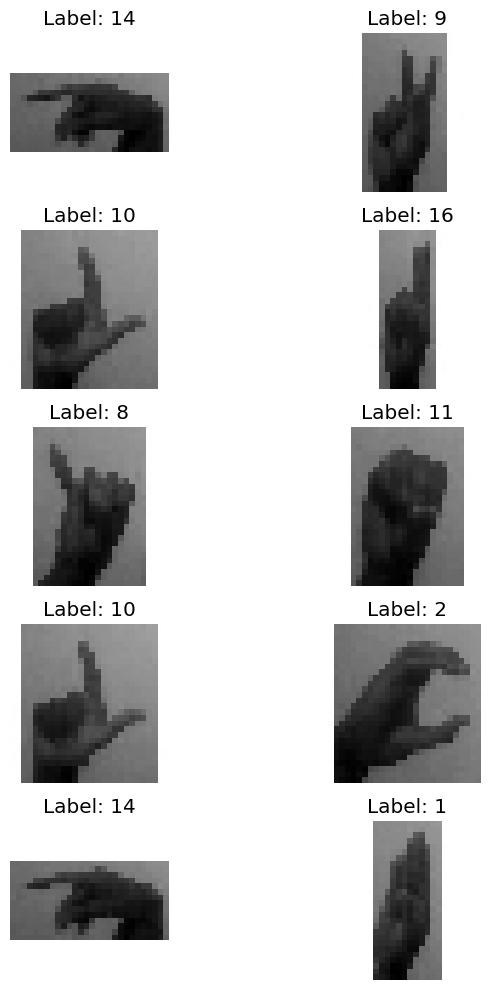

In [23]:
# Displaying the last 10 images
pixel_columns = train.columns[1:]
pixel_values = train[pixel_columns].values
labels = train['label'].values

# Get the last 10 images
last_10_images = pixel_values[-10:]
last_10_labels = labels[-10:]

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))

# Display images
for i, ax in enumerate(axes.flat):
    pixel_array = last_10_images[i].reshape(28, 28)
    ax.imshow(pixel_array, cmap='gray')
    ax.set_title('Label: ' + str(last_10_labels[i]))
    ax.axis('off')

plt.tight_layout()
plt.show()

Each Image is mapped to its respective label excluding 9 and 25 which are J and Z that are not part of the data as they involve motion

- **Checking Frequency Distribution in the sets**

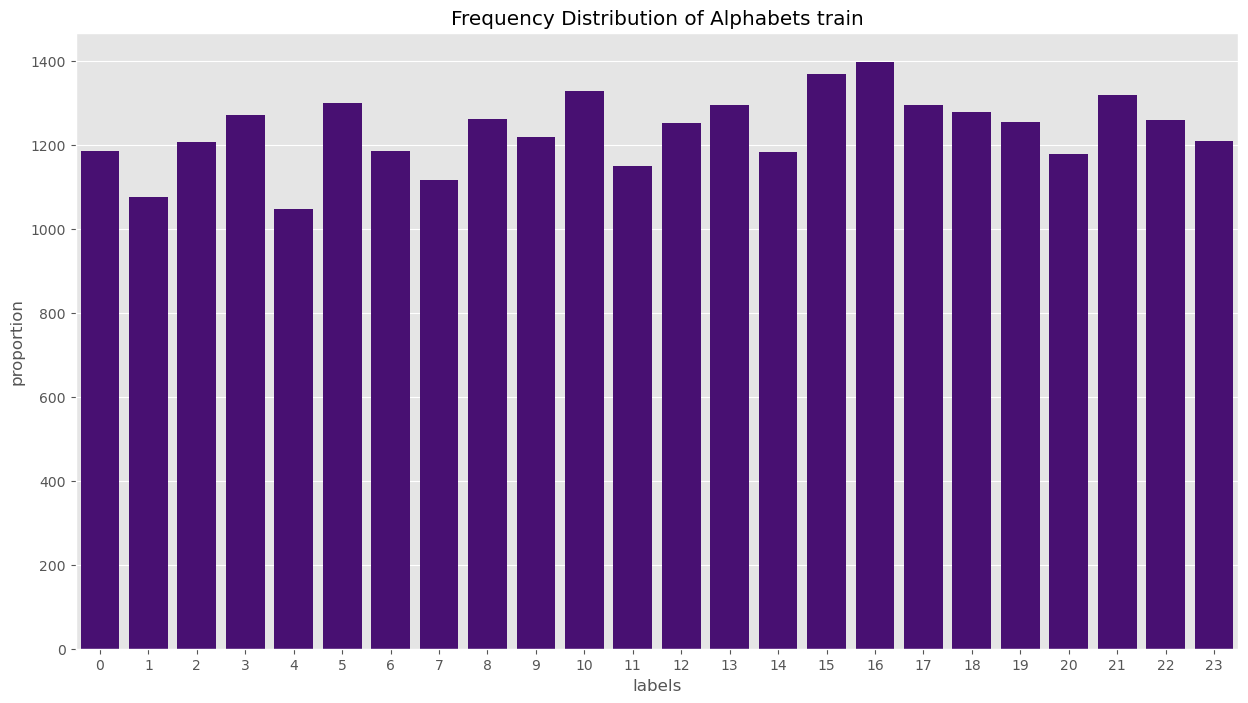

In [28]:
# Distribution of the labels column train dataset
def check_distribution(data, col, name):
  plt.figure(figsize=(15, 8)) 
  sns.countplot(data=data, x=col, color="indigo")
  plt.xlabel('labels')
  plt.ylabel('proportion')
  plt.title(f"Frequency Distribution of Alphabets {(name)}")
  plt.show();

check_distribution(train, 'label', "train")

The label column exhibits a fairly distributed class distribution with no notable class imbalances. All classes display similar proportions, indicating a well-balanced dataset. This characteristic ensures that the model will have an equal opportunity to learn from and make accurate predictions across all classes.

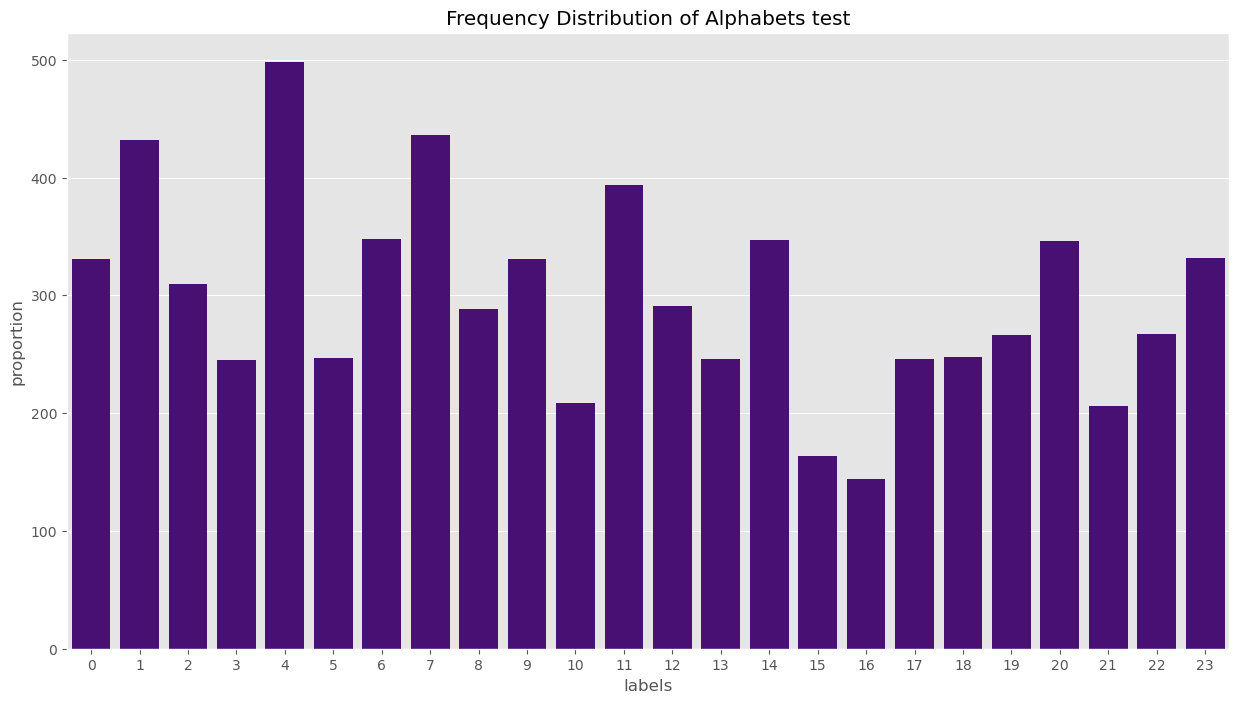

In [29]:
# Distribution of the labels column test dataset
check_distribution(test, 'label', "test")

The test dataset displays quite a bit of class imbalance which will help reflect the real-world distribution of the data that the model will encounter when its deployed.

- **Checking Pixel Distribution**

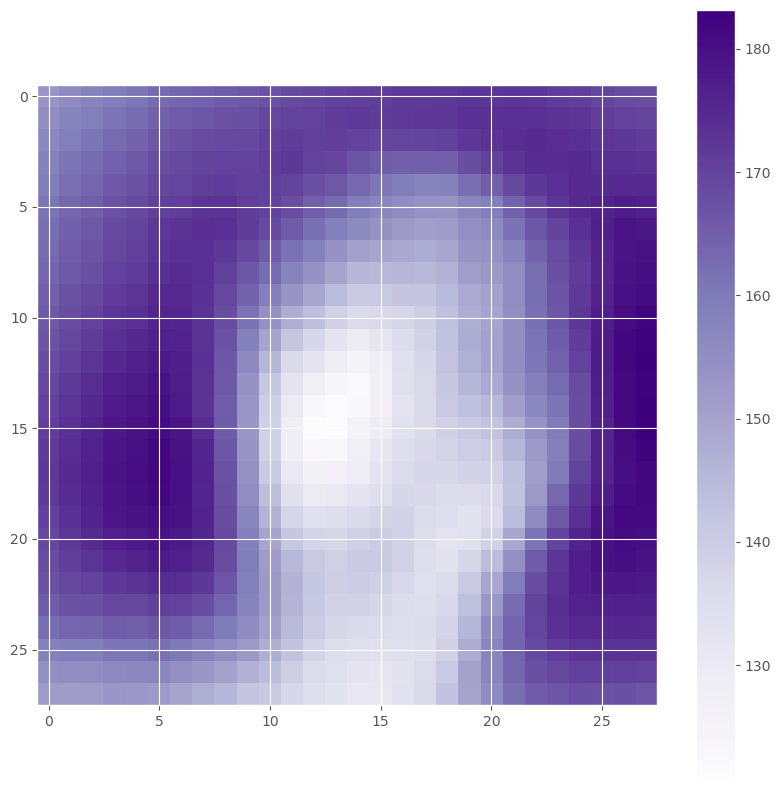

In [25]:
pixel_columns = [col for col in train.columns if col != 'label']
images = train[pixel_columns].to_numpy()

# Reshape the images
# Assuming the images are 28x28 pixels
images = images.reshape(-1, 28, 28)

# Calculate the average image
average_image = np.mean(images, axis=0)

# Plot the average image as a heatmap
plt.figure(figsize=(10,10))
plt.imshow(average_image, cmap='Purples')  # 'PuRd' is a colormap that ranges from purple to red
plt.colorbar()
plt.show()

From this heatmap, it appears that the images have higher pixel values around the edges, particularly in the top left and bottom right corners. The center of the images tends to have lower pixel values. This suggests that the hand gestures in the images might be generally centered and surrounded by a darker background.

## 6.Modelling

#### (i)  The Baseline Model

In [35]:
# two layers baseline model
baseline_model = Sequential()
baseline_model.add(layers.Dense(64, activation="relu", input_shape=(784,)))
baseline_model.add(layers.Dense(32, activation="relu"))
baseline_model.add(layers.Dense(24, activation="softmax"))

#compiling our model
baseline_model.compile(loss="categorical_crossentropy",
                       optimizer="sgd",
                       metrics=["accuracy"])

#fitting the model
baseline_history = baseline_model.fit(train_X, train_y,
                                      epochs=100, batch_size=100,
                                      validation_split=0.2)

print("Baseline model test data accuracy: ")
baseline_model.evaluate(test_X, test_y)

Epoch 1/100
238/238 [==============================] - 2s 5ms/step - loss: 3.1265 - accuracy: 0.0831 - val_loss: 3.1097 - val_accuracy: 0.0899
Epoch 2/100
238/238 [==============================] - 1s 4ms/step - loss: 2.9599 - accuracy: 0.1847 - val_loss: 3.0528 - val_accuracy: 0.1777
Epoch 3/100
238/238 [==============================] - 1s 4ms/step - loss: 2.7206 - accuracy: 0.2578 - val_loss: 3.0598 - val_accuracy: 0.2020
Epoch 4/100
238/238 [==============================] - 1s 4ms/step - loss: 2.4366 - accuracy: 0.3091 - val_loss: 3.2221 - val_accuracy: 0.2382
Epoch 5/100
238/238 [==============================] - 1s 4ms/step - loss: 2.1836 - accuracy: 0.3572 - val_loss: 3.3885 - val_accuracy: 0.2514
Epoch 6/100
238/238 [==============================] - 1s 4ms/step - loss: 1.9847 - accuracy: 0.4076 - val_loss: 3.7472 - val_accuracy: 0.2644
Epoch 7/100
238/238 [==============================] - 1s 5ms/step - loss: 1.8257 - accuracy: 0.4452 - val_loss: 4.0070 - val_accuracy: 0.2637

[1.3693368434906006, 0.7140267491340637]


The model is trained for 100 epochs with a batch size of 100. During training, 20% of the training data is used as a validation set.

From the output, it appears that the model’s training accuracy increases over time, reaching almost 100% by the 100th epoch. This suggests that the model is fitting the training data well. However, the validation accuracy is much lower and seems to decrease after a certain point. This suggests that the model may be overfitting the training data The model is evaluated on the test set, achieving an accuracy of approximately 71.40%.



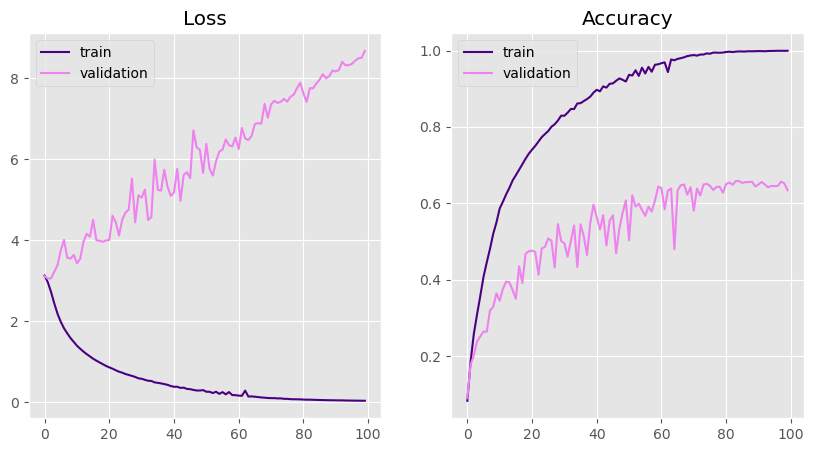

In [36]:
#Plotting the loss and accuracy of the test and validation datasets
def plot_loss_and_accuracy(results, final=False):

    if final:
        val_label="test"
    else:
        val_label="validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    # Setting up plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting loss info
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train",color="indigo")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label,color="violet")
    ax1.legend()

    # Plotting accuracy info
    ax2.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label="train",color="indigo")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label=val_label,color="violet")
    ax2.legend()

#baseline model loss and accuracy
plot_loss_and_accuracy(baseline_history)

The training loss decreases steadily over time, indicating that the model is learning from the training data. However, the validation loss initially decreases but then starts to increase after a certain point. This is a classic sign of overfitting while the model is becoming better at fitting the training data, it’s performance on unseen data is deteriorating.

The graph on the right shows the model’s accuracy over time. Again, the purple line represents training accuracy and the pink line represents validation accuracy. The training accuracy increases steadily and reaches near 100%, but the validation accuracy plateaus and even slightly decreases after a certain point. This further supports the observation of overfitting.

#### (ii) The Second Model

In [21]:

# Creating a Sequential model
model1 = Sequential()

# Adding Convolutional layers
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

# Flattenning the output from the Convolutional layers
model1.add(Flatten())

# Adding fully connected layers
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))  # Add dropout for regularization
model1.add(Dense(24, activation='softmax'))  # Adjust the output layer to match your number of classes

# Compiling the model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history1 = model1.fit(train_X_reshaped, train_y, epochs=10, batch_size=100, validation_split=0.2)

# Evaluatig the model on test data
test_loss, test_accuracy = model1.evaluate(test_X_reshaped, test_y)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/10
238/238 [==============================] - 20s 76ms/step - loss: 1.7327 - accuracy: 0.4655 - val_loss: 1.6530 - val_accuracy: 0.6346
Epoch 2/10
238/238 [==============================] - 18s 74ms/step - loss: 0.5840 - accuracy: 0.8048 - val_loss: 1.6814 - val_accuracy: 0.6743
Epoch 3/10
238/238 [==============================] - 18s 76ms/step - loss: 0.3103 - accuracy: 0.8945 - val_loss: 2.0043 - val_accuracy: 0.6992
Epoch 4/10
238/238 [==============================] - 18s 74ms/step - loss: 0.2062 - accuracy: 0.9298 - val_loss: 2.1634 - val_accuracy: 0.6783
Epoch 5/10
238/238 [==============================] - 17s 73ms/step - loss: 0.1524 - accuracy: 0.9486 - val_loss: 2.5900 - val_accuracy: 0.6791
Epoch 6/10
238/238 [==============================] - 18s 74ms/step - loss: 0.1250 - accuracy: 0.9557 - val_loss: 2.4635 - val_accuracy: 0.6861
Epoch 7/10
238/238 [==============================] - 18s 74ms/step - loss: 0.1061 - accuracy: 0.9630 - val_loss: 2.8182 - val_accuracy:


The model is trained for 10 epochs with a batch size of 100. 20% of the training data is used for validation.

The trained model is evaluated on test data.  After 10 epochs, the model achieves a test accuracy of approximately 94.50%. However, it’s worth nothing that the validation accuracy doesn’t improve much after the first few epochs, and the validation loss even increases, which might indicate overfitting.

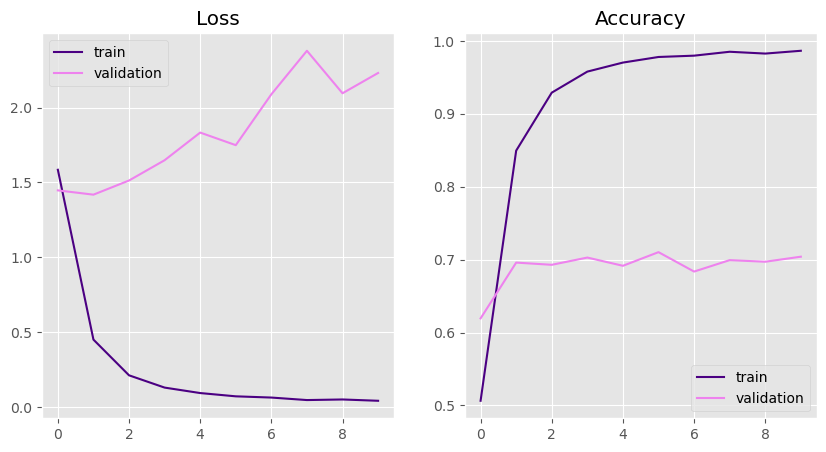

In [29]:
#evaluating the training
plot_loss_and_accuracy(history1)
plt.show()


Loss graph shows how the model’s loss changes as it goes through each epoch . The purple line represents the training loss, and the pink line represents the validation loss. The validation loss seems to decrease and then it starts increasing.This could indicate overfitting.


Accuracy graph shows how the model’s accuracy changes with each epoch. The purple line represents the training accuracy, and the pink line represents the validation accuracy. The accuracy of the training data seems to increase while the validation increases then plateaus overtime.

In [42]:
#Making Predictions
predictions1 = model1.predict(test_X_reshaped)
pred_labels1 = pd.Series([np.argmax(x) for x in predictions1])

225/225 [==============================] - 3s 10ms/step


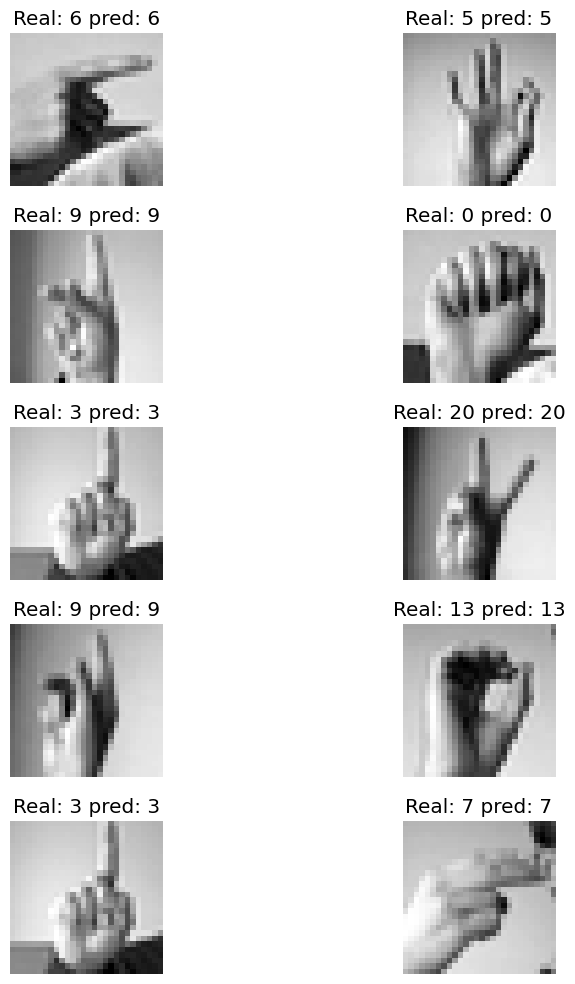

In [43]:
#displaying images
# Extract pixel values and labels
pixel_columns = test.columns[1:]
pixel_values = test[pixel_columns].values
labels = test['label'].values
pred_labels = pred_labels1.values

# Display images
fig, axes = plt.subplots(5, 2, figsize=(8, 10))
fig.tight_layout()

# Display images
for i in range(10):
    row = i // 2
    col = i % 2
    pixel_array = pixel_values[i].reshape(28, 28)
    # Display image on the corresponding subplot
    axes[row, col].imshow(pixel_array, cmap='gray')
    axes[row, col].set_title(f"Real: {labels[i]} pred: {pred_labels1[i]}")
    axes[row, col].axis('off')

# Show the plot
plt.show()

#### (iii) The Third Model

In [30]:


# Creating a Sequential model
model2 = Sequential()

# Adding Convolutional layers with Batch Normalization and Leaky ReLU activation
model2.add(Conv2D(64, (3, 3), activation='linear', input_shape=(28, 28, 1)))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3, 3), activation='linear'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization())

# Flattenning the output from the Convolutional layers
model2.add(Flatten())

# Adding fully connected layers with Dropout
model2.add(Dense(256, activation='linear'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='linear'))
model2.add(LeakyReLU(alpha=0.1))

# Output layer with softmax activation
model2.add(Dense(24, activation='softmax'))

# Compiling the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history2 = model2.fit(train_X_reshaped, train_y, epochs=10, batch_size=128, validation_split=0.2)

# Evaluating the model on test data
test_loss, test_accuracy = model2.evaluate(test_X_reshaped, test_y)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/10
186/186 [==============================] - 50s 257ms/step - loss: 0.4838 - accuracy: 0.8494 - val_loss: 4.8531 - val_accuracy: 0.0772
Epoch 2/10
186/186 [==============================] - 42s 225ms/step - loss: 0.0408 - accuracy: 0.9874 - val_loss: 5.8745 - val_accuracy: 0.1430
Epoch 3/10
186/186 [==============================] - 42s 227ms/step - loss: 0.0232 - accuracy: 0.9930 - val_loss: 3.0789 - val_accuracy: 0.5518
Epoch 4/10
186/186 [==============================] - 40s 213ms/step - loss: 0.0259 - accuracy: 0.9916 - val_loss: 2.0032 - val_accuracy: 0.6876
Epoch 5/10
186/186 [==============================] - 41s 218ms/step - loss: 0.0214 - accuracy: 0.9933 - val_loss: 2.8316 - val_accuracy: 0.7024
Epoch 6/10
186/186 [==============================] - 42s 225ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 3.2051 - val_accuracy: 0.6852
Epoch 7/10
186/186 [==============================] - 42s 225ms/step - loss: 0.0255 - accuracy: 0.9911 - val_loss: 3.1299 - val_ac


The model is trained for 10 epochs with a batch size of 128. 20% of the training data is used for validation.The output shows the training process for each epoch, including the loss and accuracy on both training and validation sets. After 10 epochs, the model achieves a test accuracy of approximately 94.06%. This might still indicate overfitting since there there is still a big difference between the training and the test data.

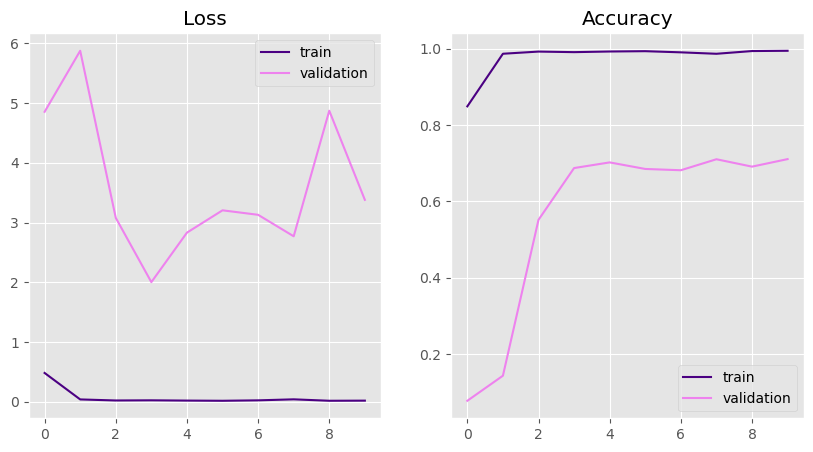

In [34]:
#evaluating model training
plot_loss_and_accuracy(history2)
plt.show()


Loss graph shows how the model’s loss changes as it goes through each epoch . The purple line represents the training loss, and the pink line represents the validation loss. The training loss seems to decrease then plateaus at 0 while the validation loss flactuates over the epochs

Accuracy graph shows how the model’s accuracy changes with each epoch. The purple line represents the training accuracy, and the pink line represents the validation accuracy. Both of the train and validation seem to increase and plateau over time

In [32]:
#Making Predictions
predictions = model2.predict(test_X_reshaped)
pred_labels = pd.Series([np.argmax(x) for x in predictions])

225/225 [==============================] - 6s 24ms/step


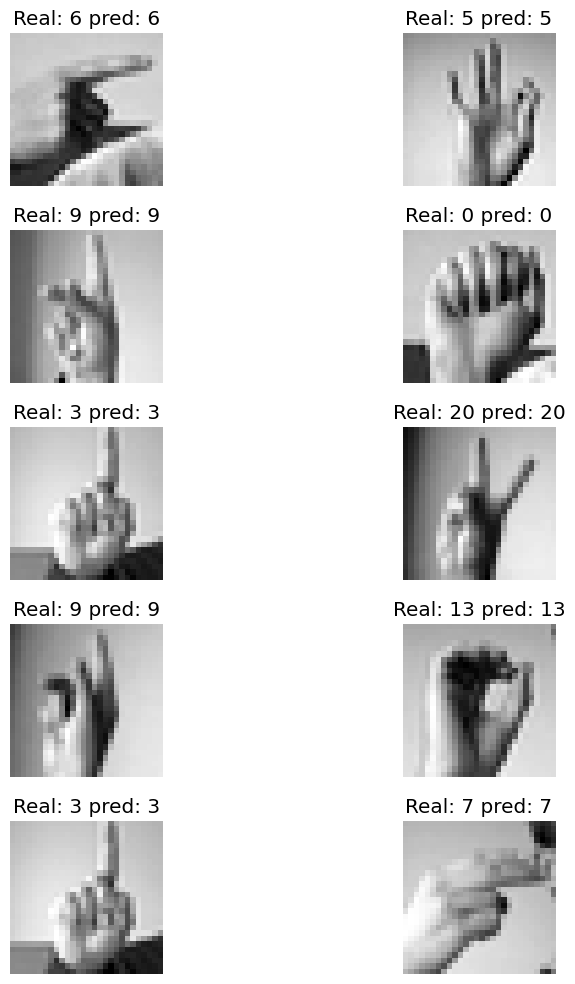

In [33]:
#displaying images
# Extract pixel values and labels
pixel_columns = test.columns[1:]
pixel_values = test[pixel_columns].values
labels = test['label'].values
pred_labels = pred_labels.values

# Display images
fig, axes = plt.subplots(5, 2, figsize=(8, 10))
fig.tight_layout()

# Display images
for i in range(10):
    row = i // 2
    col = i % 2
    pixel_array = pixel_values[i].reshape(28, 28)
    # Display image on the corresponding subplot
    axes[row, col].imshow(pixel_array, cmap='gray')
    axes[row, col].set_title(f"Real: {labels[i]} pred: {pred_labels[i]}")
    axes[row, col].axis('off')

# Show the plot
plt.show()

#### (iv) The Forth Model

In [36]:

# Add BatchNormalization layers to your model
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(24, activation='softmax'))  # Adjust the output layer to match your number of classes

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train with data augmentation
history3 = model3.fit(train_X_reshaped, train_y, batch_size=100,
                        epochs=10,
                        validation_split=0.2,
                        callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = model3.evaluate(test_X_reshaped, test_y)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/10
238/238 [==============================] - 35s 140ms/step - loss: 0.6706 - accuracy: 0.7994 - val_loss: 5.9272 - val_accuracy: 0.0400
Epoch 2/10
238/238 [==============================] - 30s 126ms/step - loss: 0.0730 - accuracy: 0.9793 - val_loss: 2.7317 - val_accuracy: 0.4869
Epoch 3/10
238/238 [==============================] - 31s 132ms/step - loss: 0.0386 - accuracy: 0.9886 - val_loss: 1.7229 - val_accuracy: 0.6808
Epoch 4/10
238/238 [==============================] - 34s 142ms/step - loss: 0.0215 - accuracy: 0.9944 - val_loss: 2.1282 - val_accuracy: 0.7110
Epoch 5/10
238/238 [==============================] - 31s 132ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 2.0689 - val_accuracy: 0.6930
Epoch 6/10
225/225 [==============================] - 3s 14ms/step - loss: 0.2662 - accuracy: 0.9462
Test accuracy: 0.9461795687675476



The model is trained for 10 epochs with a batch size of 128. 20% of the training data is used for validation.After 6 epochs, the training was stopped due to early stopping as there was no improvement in validation loss for 3 consecutive epochs. The final test accuracy achieved by this model is approximately 94.62%. This suggests that your model has learned effectively from your data and is able to generalize well to unseen data.

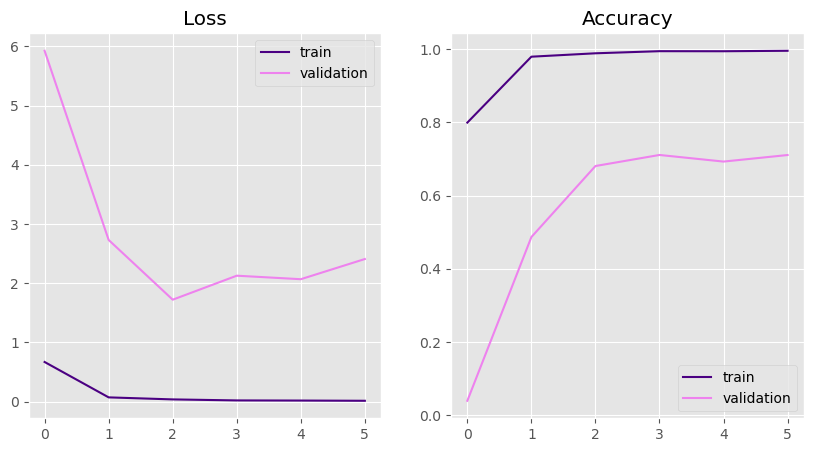

In [ ]:

#evaluating model training
plot_loss_and_accuracy(history3)
plt.show()


Loss graph shows how the model’s loss changes as it goes through each epoch . The purple line represents the training loss, and the pink line represents the validation loss. Both the validation and the train loss seem to decrease over time

Accuracy graph shows how the model’s accuracy changes with each epoch. The purple line represents the training accuracy, and the pink line represents the validation accuracy. Both the accuracy of the validation and train seem to increase over time

In [45]:
#Making Predictions
predictions3 = model3.predict(test_X_reshaped)
pred_labels3 = pd.Series([np.argmax(x) for x in predictions3])

  6/225 [..............................] - ETA: 2s 

225/225 [==============================] - 3s 13ms/step


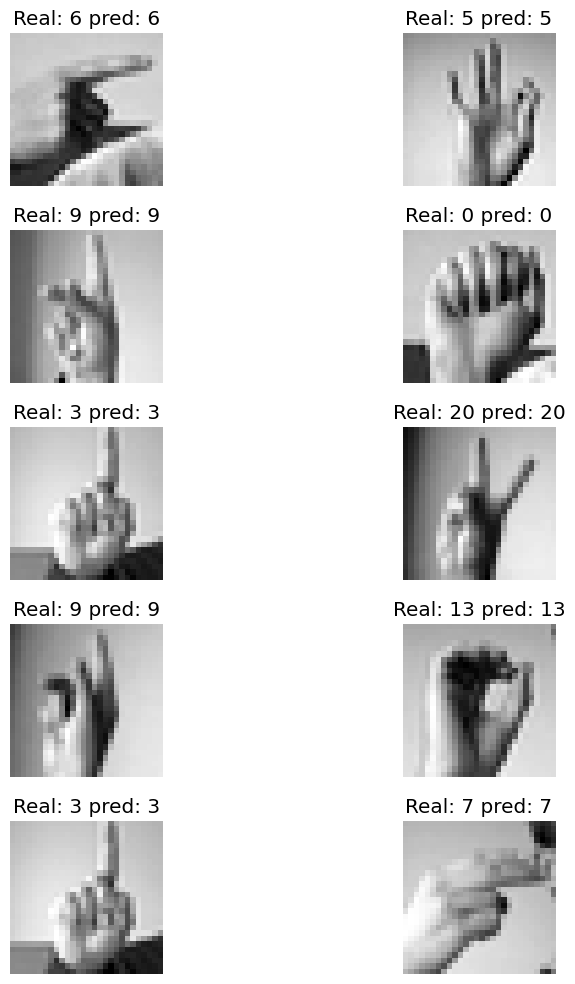

In [46]:
#displaying images
# Extract pixel values and labels
pixel_columns = test.columns[1:]
pixel_values = test[pixel_columns].values
labels = test['label'].values
pred_labels = pred_labels3.values

# Display images
fig, axes = plt.subplots(5, 2, figsize=(8, 10))
fig.tight_layout()

# Display images
for i in range(10):
    row = i // 2
    col = i % 2
    pixel_array = pixel_values[i].reshape(28, 28)
    # Display image on the corresponding subplot
    axes[row, col].imshow(pixel_array, cmap='gray')
    axes[row, col].set_title(f"Real: {labels[i]} pred: {pred_labels3[i]}")
    axes[row, col].axis('off')

# Show the plot
plt.show()

#### Saving the model

In [39]:
#Saving the model
model1.save(r"C:\Users\dell 5450\Documents\Projects\project_deployment\best_model.h5")
model3.save(r"C:\Users\dell 5450\Documents\Projects\project_deployment2\best_model.h5")

## 7. Modelling Results

**Baseline Model**

- **Model Creation**: The first hidden layer has 64 neurons and uses the ReLU (Rectified Linear Unit) activation function. The second hidden layer has 32 neurons and also uses the ReLU activation function. The output layer has 24 neurons and uses the softmax activation function to output a probability distribution over the classes. The model is compiled with the categorical cross-entropy loss function, the stochastic gradient descent (SGD) optimizer, and accuracy as the evaluation metric.

- **Training**: The model is trained for 100 epochs with a batch size of 100. During training, 20% of the training data is used as a validation set. From the output, it appears that the model’s training accuracy increases over time, reaching almost 100% by the 100th epoch. This suggests that the model is fitting the training data well.

- **Validation**: However, the validation accuracy is much lower and seems to decrease after a certain point. This suggests that the model may be overfitting the training data it’s learning the training data very well but failing to generalize to unseen data.

- **Model Evaluation**: The model is evaluated on the test set, achieving an accuracy of approximately 71.04%. This lower accuracy on the test set compared to the training set further supports the idea that the model might be overfitting on the training data.




**The First Model**

- **Model Creation**: The first layer is a Convolutional layers (Conv2D) that use ReLU activation functions to apply filters to the input data, adding non-linearity to the network. This is followed by MaxPooling layers (MaxPooling2D) which reduce the spatial dimensions of the output volume, thereby decreasing the computational power required. The data is then flattened from a 2D matrix into a 1D vector using a Flatten layer, making it compatible for the subsequent layers. The model also includes Fully connected layers (Dense) with ReLU and Softmax activation functions, connecting every neuron in one layer to every neuron in the next layer. The Softmax function is typically used in the output layer for predicting classes. Lastly, a Dropout layer is used for regularization, randomly turning off a fraction of neurons during training to prevent overfitting. 

- **Model Training**: The model is trained for 10 epochs with a batch size of 100. During training, 20% of the training data is used as a validation set. The training accuracy of the model increases over time, suggesting that the model is learning from the training data.

- **Validation**: However, the validation accuracy doesn’t improve much after the first few epochs, and the validation loss even increases. This could be a sign of overfitting, which means that the model might be learning the training data too well and is unable to generalize to unseen data.

- **Model Evaluation**: The trained model is evaluated on test data. After 10 epochs, the model achieves a test accuracy of approximately 94.06%. This suggests that your model has learned effectively from your data and is able to generalize well to unseen data.


**The Second Model**

- **Model creation** :The sequential model is constructed layer by layer. It starts with Conv2D layers that apply filters to the input data, followed by MaxPooling2D layers that reduce the spatial dimensions. The Flatten layer then transforms the 2D data into a 1D vector, which is fed into Dense layers. These Dense layers are fully connected and use ReLU and Softmax activation functions. The Dropout layer is added for regularization.

- **Training**: From Epoch 1 to Epoch 10, we can see that the model’s accuracy on the training data improves across the epochs, indicating that the model is learning from the training data. However, the validation accuracy fluctuates and doesn’t show a consistent improvement, suggesting that the model might be overfitting to the training data.

- **Model Evaluation**:After all epochs are completed, the model is evaluated on a separate test dataset (225 steps), resulting in a test accuracy of approximately 0.9450. This suggests that the trained model is about 94.50% accurate in classifying new, unseen data.



**The Third Model**

- **Model Creation**:The model is a sequential deep learning model that includes several layers. It starts with Convolutional layers (Conv2D) that apply filters to the input data, followed by Batch Normalization layers that normalize the activations of the previous layer. This is followed by MaxPooling2D layers which reduce the spatial dimensions of the output volume. The data is then flattened from a 2D matrix into a 1D vector using a Flatten layer, making it compatible for the subsequent layers. The model also includes Dense layers with ReLU activation functions and a Dropout layer for regularization. The output layer uses a softmax activation function for multi-class classification.
The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric. An EarlyStopping callback is added to stop training when the validation loss has not improved for 3 epochs, preventing overfitting.

- **Training**: The model learns from the training data over 10 epochs with a batch size of 128, using 20% of the training data for validation. The output shows that after 6 epochs, the training was stopped due to early stopping as there was no improvement in validation loss for 3 consecutive epochs.The model peaks at an accuracy of 99.48%

- **Model Evaluation**: The final test accuracy achieved by this model is approximately 94.62%. This high accuracy suggests that your model has learned effectively from your data and is able to generalize well to unseen data, making accurate predictions.

## 8. Conclusions

1. The pixel distribution image shows a higher concentration of pixels in the center, which could suggest that the images used for training have important features located in the center. This could potentially impact how the models learn from the data.

2. The Baseline Model and the Second Model show signs of overfitting, as indicated by high training accuracy and lower validation accuracy. This suggests that these models might be learning the training data too well and failing to generalize to unseen data.

3. The First Model and the Third Model have shown better performance with higher test accuracy, suggesting they have learned effectively from the data and are able to generalize well to unseen data.

4. The complexity of the models varies, with the Baseline Model being the simplest and the Third Model being the most complex. The performance of the models seems to correlate with their complexity, suggesting that a more complex model might be necessary for this task.

5. The use of Dropout layers in your models helps prevent overfitting by randomly turning off a fraction of neurons during training. However, overfitting still seems to be an issue in some models, suggesting that additional regularization techniques or adjustments might be necessary.

## 9. Recommendations

1. For models showing signs of overfitting (Baseline and Second Model), consider implementing regularization techniques such as dropout or early stopping. Increasing the training data could also be helpful in reducing overfitting.

2. For models with better performance (First and Third Model), continuous monitoring of their performance on new unseen data over time may ensure their high performance remains consistent.

3. If important features are indeed concentrated in the center of your images,investigating techniques such as center-cropping during preprocessing, or attention mechanisms that can focus on important parts of an image may be useful in reducing the noise in the images therefore increasing peformance of the models.

4. The Third Model appears to be the best choice for this task. This model includes various techniques to prevent overfitting. It achieves a high training accuracy of 99.48% and a test accuracy of approximately 94.62%, suggesting that it has learned effectively from the data and is able to generalize well to unseen data.

5. In the presesnce of computational resources and time, We recommend experimentation on different model parameters such as increasing the number of epochs and fine tunning the learning rateof the models.This might lead to better performance of the model.

## 10. Next Steps

1. Evaluate the models on a regular basis using new, unseen data to ensure they continue to perform well and can generalize to new data.

2. Setting up a system for monitoring model performance over time. This will allow you to quickly identify and address any issues that may arise.

3. Consider using pretrained models which have been trained on large datasets and have proven success in image classification tasks. These models can be fine-tuned on your specific task and often provide a good starting point.